 # Exercise 17 - Deep Learning with OpenCV

1. Write a program that blurs all the faces in the input image.

2. Search the internet to find a deep learning model that loads into OpenCV that colors a black and white image.

Processed image saved to output_blurred.jpg


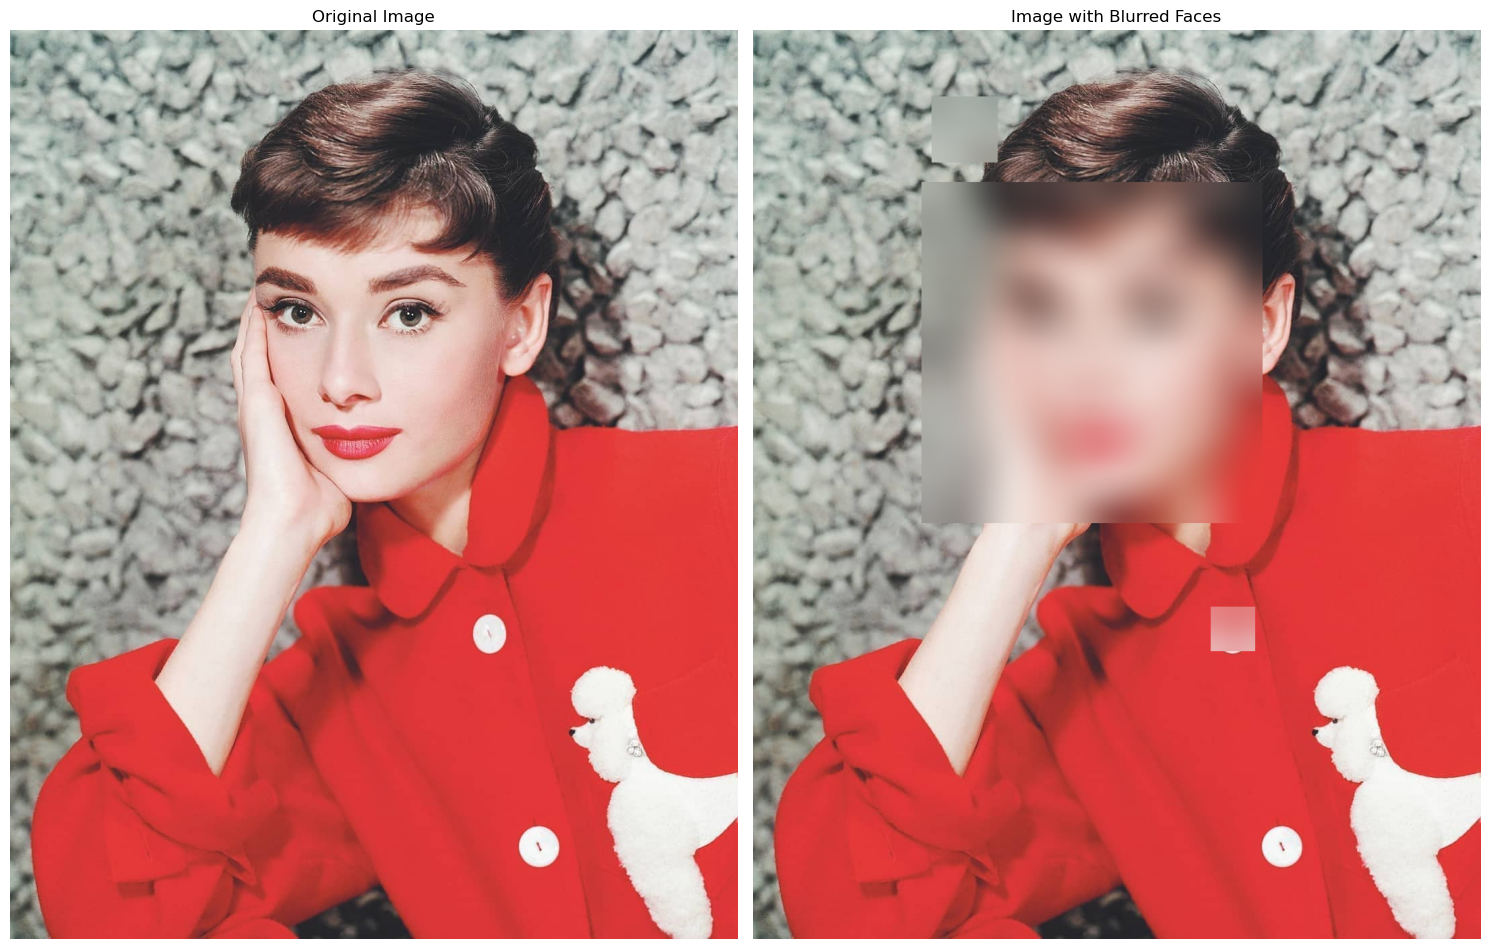

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def blur_faces(input_image_path, output_image_path):
    # Load the image
    image = cv2.imread(input_image_path)
    if image is None:
        print("Error: Could not read image")
        return
    
    # Convert from BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load the pre-trained face detection model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Convert to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # Make a copy of the original image for blurring
    blurred_image = image.copy()
    
    # Blur each detected face
    for (x, y, w, h) in faces:
        # Extract the face region
        face_region = blurred_image[y:y+h, x:x+w]
        
        # Apply blur to the face region
        blurred_face = cv2.GaussianBlur(face_region, (99, 99), 30)
        
        # Put the blurred face back into the image
        blurred_image[y:y+h, x:x+w] = blurred_face
    
    # Convert blurred image to RGB
    blurred_image_rgb = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB)
    
    # Save the result
    cv2.imwrite(output_image_path, blurred_image)
    print(f"Processed image saved to {output_image_path}")
    
    # Display the original and blurred images side by side
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(blurred_image_rgb)
    plt.title('Image with Blurred Faces')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
blur_faces(r'D:\exam\face_image1.jpg', "output_blurred.jpg")

# Image Colorization with Deep Learning

This script transforms grayscale (black & white) images into colorized versions using a pre-trained deep learning model. The implementation leverages OpenCV's dnn module with a Caffe-based colorization model.

## How It Works

1. **Model Architecture**:
   - Uses a convolutional neural network (CNN) specifically trained for image colorization
   - The model predicts chrominance (color) channels (a, b) from the luminance (brightness) channel (L) in LAB color space

2. **Processing Pipeline**:
   - Converts input image to LAB color space
   - Extracts the L channel (lightness)
   - Uses the neural network to predict a and b color channels
   - Combines the original L channel with predicted a,b channels
   - Converts back to RGB color space for display

3. **Key Features**:
   - Preserves original image structure while adding plausible colors
   - Works with various image sizes (automatically resizes for model processing)
   - Displays original and colorized images side-by-side for comparison
   - Optionally saves the colorized output

## Requirements

- OpenCV (with dnn module)
- NumPy
- Matplotlib (for display in Jupyter)

## Usage

Simply call the `colorize_image()` function with:
- Input image path
- Optional output path for saving the result

Example:
```python
colorized = colorize_image('input_gray.jpg', 'colorized_output.jpg')

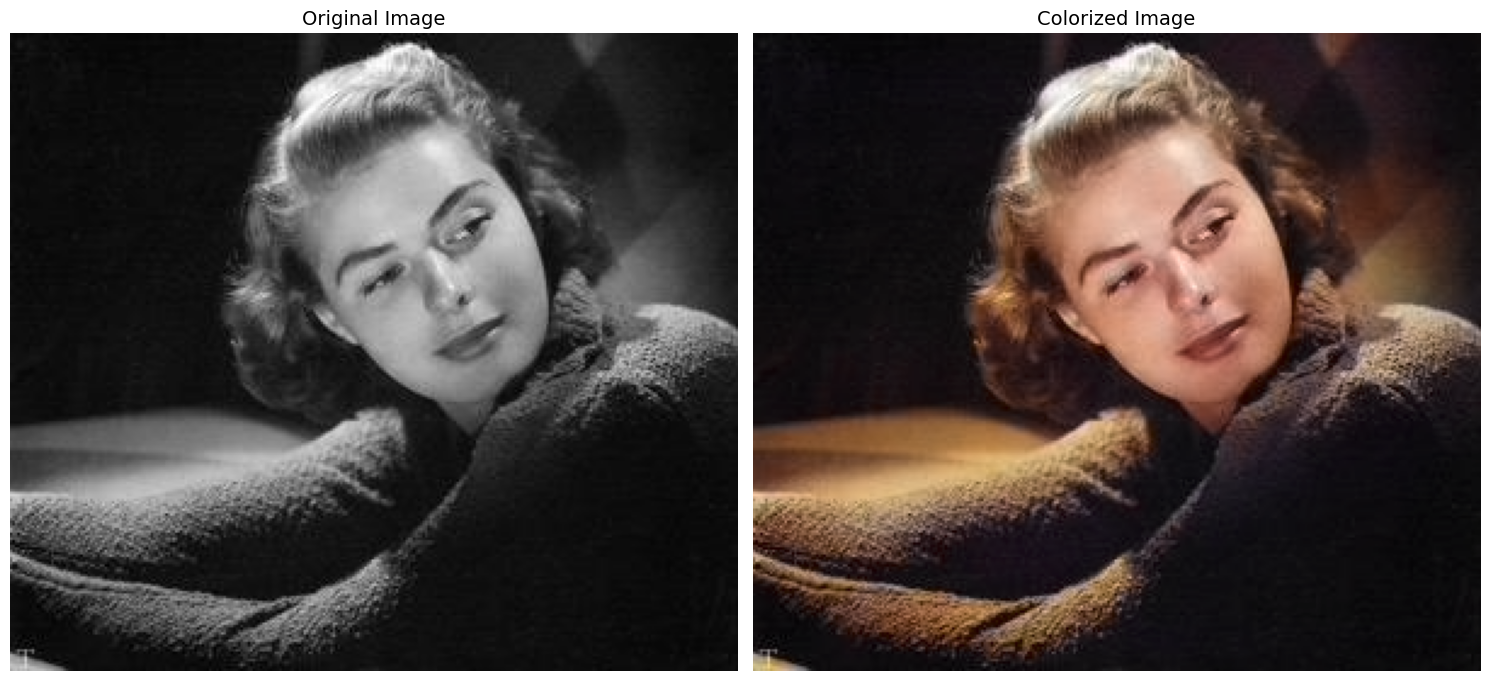

Colorized image saved to colorized_output.jpg


In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
%matplotlib inline

def colorize_image(image_path, output_path=None):
    # مسیر فایل‌های مدل (فرض می‌کنیم در پوشه colorization_models قرار دارند)
    model_dir = 'colorization_models'
    prototxt = os.path.join(model_dir, 'colorization_deploy_v2.prototxt')
    model = os.path.join(model_dir, 'colorization_release_v2.caffemodel')
    pts = os.path.join(model_dir, 'pts_in_hull.npy')
    
    # بررسی وجود فایل‌های مدل
    if not all(os.path.exists(f) for f in [prototxt, model, pts]):
        print("Error: Model files not found. Please ensure you have:")
        print(f"- {prototxt}")
        print(f"- {model}")
        print(f"- {pts}")
        return None
    
    # بارگذاری مدل
    net = cv2.dnn.readNetFromCaffe(prototxt, model)
    pts = np.load(pts)
    
    # تنظیم پارامترهای مدل
    class8 = net.getLayerId("class8_ab")
    conv8 = net.getLayerId("conv8_313_rh")
    pts = pts.transpose().reshape(2, 313, 1, 1)
    net.getLayer(class8).blobs = [pts.astype("float32")]
    net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]
    
    # بارگذاری تصویر ورودی
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image from {image_path}")
        return None
    
    # تبدیل به تصویر سیاه و سفید (اگر رنگی باشد)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    
    # پیش‌پردازش تصویر
    normalized = gray.astype("float32") / 255.0
    lab = cv2.cvtColor(normalized, cv2.COLOR_RGB2LAB)
    
    # تغییر سایز برای مدل
    resized = cv2.resize(lab, (224, 224))
    L = cv2.split(resized)[0]
    L -= 50  # تنظیم روشنایی
    
    # پردازش با مدل
    net.setInput(cv2.dnn.blobFromImage(L))
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
    
    # بازگرداندن به اندازه اصلی
    ab = cv2.resize(ab, (image.shape[1], image.shape[0]))
    
    # ترکیب کانال‌ها
    L = cv2.split(lab)[0]
    colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)
    
    # تبدیل به RGB
    colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2RGB)
    colorized = (255 * colorized).astype("uint8")
    
    # نمایش نتایج
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image', fontsize=14)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(colorized)
    plt.title('Colorized Image', fontsize=14)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # ذخیره تصویر خروجی
    if output_path:
        cv2.imwrite(output_path, cv2.cvtColor(colorized, cv2.COLOR_RGB2BGR))
        print(f"Colorized image saved to {output_path}")
    
    return colorized

# مثال استفاده:
colorized = colorize_image(r'D:\exam\gray_image.jpg', 'colorized_output.jpg')